In [1]:
# Leo Simpson, University of Freiburg, Tool-Temp AG, 2023

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [3]:
import sys, os
from os.path import join, dirname
main_dir = dirname(os.getcwd())
sys.path.append(main_dir)

In [4]:
import numpy as np
import matplotlib.pyplot as plt # type: ignore
import casadi as ca # type: ignore
from src import ProblemParser, ModelParser # main objects to use the present algorithms
from src import plot_data, plot_est, plot_res # plotting tools
from time import time
rng = np.random.default_rng(seed=42)

# Define the model

In [5]:
beta_min = 1e-6
beta_max = 1.
def dynamic(x, u, alpha, beta): 
    # construction of the output
    x_plus = x
    y = x
    
    # noise model
    Q =  beta[0] *  ca.DM.eye(1)
    R =  beta[1] *  ca.DM.eye(1)
    
    # inequality constraints on the form h > 0
    h = ca.vertcat(alpha+1., 1. - alpha, beta - beta_min, beta_max - beta)
    return x_plus, y, Q, R, h

# note that in the present case, both u and alpha are actually useless (they are just here to avoid exceptions)

In [6]:
# Define the model with Casadi symbolics
x_symbol = ca.SX.sym("x", 1)
u_symbol = ca.SX.sym("u", 1)
alpha_symbol = ca.SX.sym("alpha",1)
beta_symbol = ca.SX.sym("beta", 2)
xplus_symbol, y_symbol, Q_symbol, R_symbol, h_symbol = dynamic(x_symbol, u_symbol, alpha_symbol, beta_symbol)

In [7]:
# Define a Casadi functions associated with the model
xplus_fn = ca.Function("xplus", [x_symbol, u_symbol, alpha_symbol], [xplus_symbol])
y_fn = ca.Function("y", [x_symbol], [y_symbol])
Q_fn = ca.Function("Q", [beta_symbol], [Q_symbol])
R_fn = ca.Function("R", [beta_symbol], [R_symbol])
h_fn = ca.Function("h", [alpha_symbol, beta_symbol], [h_symbol])

# Generate the problem

## Define the true model 

In [8]:
# make model Parser
model_true = ModelParser(xplus_fn, y_fn, Q_fn, R_fn)

alpha_true = 0.
beta_true = np.array([1e-1, 1e-2]) # Q, R

In [9]:
x0 = np.zeros(model_true.nx)
P0 = np.eye(model_true.nx) * 0.

## Generate Data 

In [10]:
Ntest = 500
Ntrain = 2000
umax = 50

us_train = model_true.generate_u(rng, Ntrain, umax=umax, step = 10) # actually useless in the present case
ys_train, _ = model_true.simulation(x0, us_train, alpha_true,  beta_true, rng)

us_test = model_true.generate_u(rng, Ntest, umax=umax, step = 10)
ys_test, _ = model_true.simulation(x0, us_test, alpha_true, beta_true, rng)

<IPython.core.display.Javascript object>


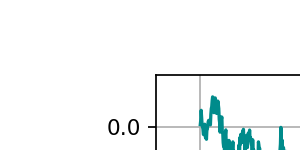

In [11]:
fig = plot_data(None, ys_train)

# Estimation

In [12]:
# Here we use the model that is assumed
model = ModelParser(xplus_fn, y_fn, Q_fn, R_fn)
model.Ineq = h_fn
assert model.feasible(alpha_true, beta_true), "Constraints should be satisfied for the true parameters"

In [13]:
# the flag lti allow to speed things up for LTI systems 
problemTrain = ProblemParser(model, ys_train, us_train, x0, P0, lti=True)
problemTest = ProblemParser(model, ys_test, us_test, x0, P0)

In [14]:
# define the initial point for optimization
beta0 = np.ones(model.nbeta)
alpha0 = np.zeros(model.nalpha)

## Optimize over the Kalman filter 

In [15]:
formulation = "Exact" # can be "Exact", "Approx"
algorithm = "SQP" # can be "SQP" or "IPOPT"

opts = {"pen_step":1e-4, "maxiter":20, "tol.direction":0., "tol.kkt":1e-8} # parameters of the SQP method

In [16]:
t0 = time()
alpha_found, beta_found, stats = problemTrain.solve(alpha0, beta0, formulation, algorithm, opts=opts, verbose=False)
rtime = time() - t0
print("running time : {:.2e}  status : {}".format(rtime, stats["return_status"]))

running time : 4.68e+00  status : rtol.cost_decrease


In [17]:
print( alpha_true, alpha_found)
print(beta_true, beta_found)

0.0 [0.]
[0.1  0.01] [0.09421372 0.01310655]


### Validation on out-of-sample data 

In [18]:
xs_est, ys_est = problemTest.kalman(alpha_found, beta_found)

npred = 10
t_pred, y_pred =  model.predictions(us_test, xs_est, alpha_found, npred)

<IPython.core.display.Javascript object>


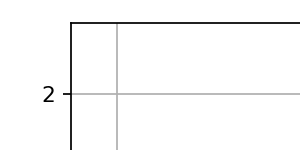

In [19]:
fig = plot_est(None, ys_test, ys_est, pred=(t_pred, y_pred))